In [1]:
import torch

from seq2seq.data import Dataset
from seq2seq.model import Seq2seqModel
from seq2seq.train import Trainer, Evaluator

In [2]:
GPU_ID = 1
device = torch.device("cuda:{}".format(GPU_ID)) if torch.cuda.is_available() else torch.device("cpu")

# 1. Preprocess Data

In [3]:
SRC_FILE_PATH = 'smart_mobile/smart_src_khaiii.txt'
TGT_FILE_PATH = 'smart_mobile/smart_tgt_khaiii.txt'

EXPR_PATH = 'smart_mobile/'

BATCH_SIZE = 32
MAX_SRC_LEN = 10
MAX_TGT_LEN = 10

In [4]:
%%time
dataset = Dataset(
    src_file_path=SRC_FILE_PATH,
    tgt_file_path=TGT_FILE_PATH,
    max_src_len=MAX_SRC_LEN,
    max_tgt_len=MAX_TGT_LEN
)

Reading lines...
Read 90729 sentence pairs

Trim data to 20074 sentence pairs
Avg length of src :  7.272591411776427
Avg length of tgt :  7.307063863704294

Source vocab : 5062 (0 reduced)
Target vocab : 5060 (0 reduced)

Success to preprocess data!

CPU times: user 857 ms, sys: 133 ms, total: 990 ms
Wall time: 985 ms


# 2. Define Model

In [5]:
NUM_LAYERS = 1
INPUT_SIZE = dataset.src_vocab_size
EMBED_SIZE = 64
HIDDEN_SIZE = 64
OUTPUT_SIZE = dataset.tgt_vocab_size

In [6]:
model = Seq2seqModel(
    n_layers=NUM_LAYERS,
    input_size=INPUT_SIZE,
    emb_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    max_tgt_len=MAX_TGT_LEN,
    dropout_p=0.0,
    bi_encoder=True
).to(device)

In [7]:
model

Seq2seqModel(
  (encoder): EncoderRNN(
    (embedding): Embedding(5062, 64, padding_idx=0)
    (rnn): GRU(64, 64, batch_first=True, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(5060, 64, padding_idx=0)
    (rnn): GRU(64, 128, batch_first=True)
    (attn): Attn(
      (W): Linear(in_features=256, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=5060, bias=True)
    (softmax): LogSoftmax()
  )
)

# 3. Train Model

In [8]:
trainer = Trainer(
    model,
    dataset,
    device=device,
    print_interval=1,
    plot_interval=-1,
    checkpoint_interval=10,
    expr_path=EXPR_PATH
)

In [9]:
trainer.train(num_epoch=10, batch_size=BATCH_SIZE)

Start to train


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch:  1 ( 10%) time:    0m 22s (-     3m 23s) loss:2242.8427
epoch:  2 ( 20%) time:    0m 44s (-     2m 58s) loss:1658.0699
epoch:  3 ( 30%) time:     1m 5s (-     2m 33s) loss:1491.0367
epoch:  4 ( 40%) time:    1m 27s (-     2m 11s) loss:1380.6761
epoch:  5 ( 50%) time:    1m 50s (-     1m 50s) loss:1293.1125
epoch:  6 ( 60%) time:    2m 12s (-     1m 28s) loss:1217.7187
epoch:  7 ( 70%) time:    2m 35s (-      1m 6s) loss:1149.8852
epoch:  8 ( 80%) time:    2m 58s (-     0m 44s) loss:1087.2026
epoch:  9 ( 90%) time:    3m 20s (-     0m 22s) loss:1028.5426
epoch: 10 (100%) time:    3m 42s (-      0m 0s) loss:973.3087


# 4. Evaluate Model

In [10]:
evaluator = Evaluator(dataset, model)
evaluator.loadModel(EXPR_PATH+'test_model10.model')

FileNotFoundError: [Errno 2] No such file or directory: 'smart_mobile/test_model10.model'

Input : 30 5 17 39 18 20 2
Gen   : 2 20 18 39 17 5 30 <EOS>


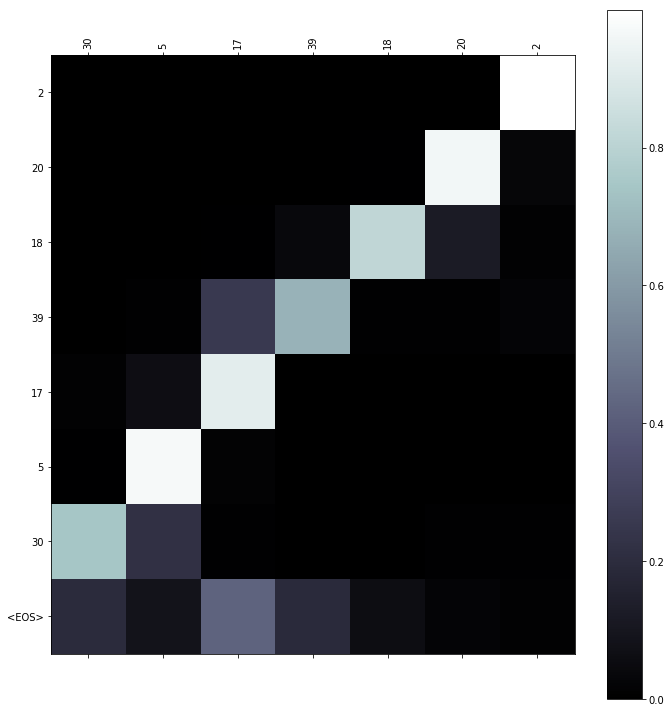


Input : 21 2 40 21 35 34 26 46 39 13
Gen   : 13 39 46 26 34 35 <EOS>


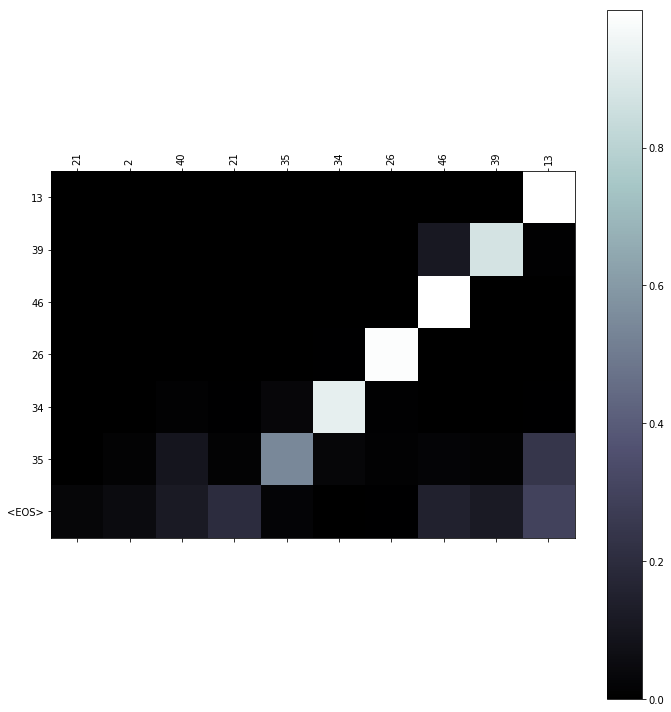


Input : 50 3 26
Gen   : 26 3 50 50 <EOS>


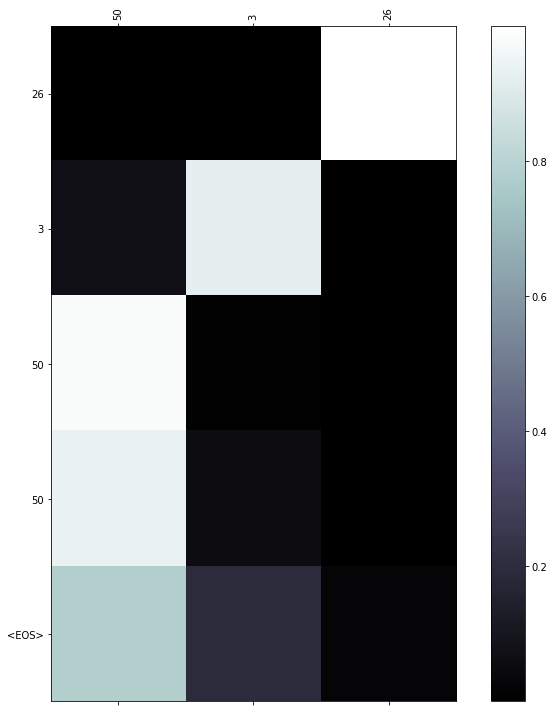

In [10]:
pairs, attn_list = evaluator.evalModel(num=3, beam_size=5)
for p, attn in zip(pairs, attn_list):
    print('Input : ' + ' '.join(p[0]))
    print('Gen   : ' + ' '.join(p[1]))
    vizAttn(p[0], p[1], attn)
    print()